# Generate Catalogue for JWST NIRSpec acquisition - 7 June 2023

In [1]:
#given an input catalogue, generates the list of reference targets and appends 
#to a new file appended with 'reference_targets' """
import numpy as np
from astropy.io import fits, ascii
import astropy.units as u
from astropy.coordinates import SkyCoord
from scipy.spatial import cKDTree
import os
import tqdm
import pylab as plt



# Read NIRCAM photometry 


In [2]:
#Read NIRCAM catalogue

j = fits.open('jw02301-o002_t200_nircam_clear-f115w_cat.fits')
jid = j[1].data['label']
jra = j[1].data['sky_centroid.ra']
jdec = j[1].data['sky_centroid.dec']
jext = j[1].data['is_extended']
jsharp = j[1].data['sharpness']
jround = j[1].data['roundness']
jmag = j[1].data['aper_total_vegamag']


# *********************************************************************************** 
# Read HST Photometry and define sub-samples 
# (reference stars, target stars, fillers) 
# ************************************************************************************


In [3]:
refmag = 'NRS_F110W'
a = fits.open('phat_b13_v1_gst_concat.fits')
ara = a[1].data['RA']
adec = a[1].data['DEC']
amag1 = a[1].data['MAG1_IR']
amag2 = a[1].data['MAG2_IR']



# Match the two catalogues

In [80]:
#Match PHAT and JWST catalogues

#Maximum Separation parameter, in arcsec
msep = 0.1

from astropy.coordinates import SkyCoord, match_coordinates_sky

#define sky coordinate object for each star in both catalogues
#d2d = on-sky separation between targets, d3d = 3D distance between targets
#idx = catalogue indices of closest matches 


phat_pos = SkyCoord(ra = ara*u.degree, dec=adec*u.degree, frame='icrs')
jwst_pos = SkyCoord(ra = jra*u.degree, dec=jdec*u.degree, frame='icrs')
idx, d2d, d3d = match_coordinates_sky(jwst_pos, phat_pos)
#In this case, idx[i] gives you the index of the entry in the phat catalog whose coordinates match 
#the entry i in jwst catalogue.  In other words:  jra[i] = ara[indx[i]]

# msep arcsec separation 
max_sep = msep*u.arcsec
def_match = d2d < max_sep

#Obtaining the coordinates of sources within each catalogue that are a match
matches = jwst_pos[def_match]
catalog_matches = phat_pos[idx][def_match]

print(max_sep)
print(idx)
print(jra[5567],ara[idx[5567]])
print(len(jra),len(ara),len(d2d),len(def_match),len(catalog_matches))

0.1 arcsec
[ 22554    547   2637 ... 224498 216658 211738]
11.305082410937645 11.30516167
128328 271572 128328 128328 100356


In [81]:
mean_sep = np.mean(d2d[def_match])
maximum_sep = np.max(d2d[def_match])
print(mean_sep,maximum_sep)

0d00m00.04680098s 0d00m00.09999906s


# Create vectors assigning PHAT photometry to JWST catalogue

In [198]:
jid_fin = jid[def_match]
jra_fin = jra[def_match]
jdec_fin = jdec[def_match]
pmag1_fin = amag1[idx][def_match]
pmag2_fin = amag2[idx][def_match]
jext_fin = jext[def_match]
jmag_fin = jmag[def_match]

print(len(jid_fin),len(jra_fin),len(jdec_fin))
print(len(pmag1_fin),len(pmag2_fin),len(jext_fin),len(jmag_fin))

100356 100356 100356
100356 100356 100356 100356


In [191]:
#This includes only the stars with good cross-match between JWST and PHAT.  
#Note that the astrometry that is carried through is that from JWST/NIRCAM


jra_fin = np.zeros(len(jra[def_match]))
jdec_fin = np.zeros(len(jra[def_match]))
pmag1_fin = np.zeros(len(jra[def_match]))
pmag2_fin = np.zeros(len(jra[def_match]))
jid_fin = np.zeros(len(jra[def_match]))
jext_fin = np.zeros(len(jra[def_match]))
jmag_fin = np.zeros(len(jra[def_match]))

m=0

for i in tqdm.tqdm(range(len(jra))):
    if def_match[i] == True:
        jid_fin[m] = jid[i]
        jra_fin[m] = jra[i]
        jdec_fin[m] = jdec[i]
        pmag1_fin[m] = amag1[i]
        pmag2_fin[m] = amag2[i]
        jext_fin[m] = jext[i]
        jmag_fin[m] = jmag[i]
        m=m+1
        
print(len(jra_fin))

#Save Cluster star IDs and coordinates to a fits file
#Instructionc collected from https://docs.astropy.org/en/stable/io/fits/#creating-a-new-fits-file
col1 = fits.Column(name='ID', array=jid_fin, format='K')
col2 = fits.Column(name='RA', array=jra_fin, format='D')
col3 = fits.Column(name='DEC', array=jdec_fin, format='D')
col4 = fits.Column(name='MAG1_IR', array=pmag1_fin, format='F')
col5 = fits.Column(name='MAG2_IR', array=pmag2_fin, format='F')
cols = fits.ColDefs([col1,col2,col3,col4,col5])
hdu = fits.BinTableHDU.from_columns(cols)
#hdu.writeto('matched_catalog.fits')


# Create vectors of bright stars for search of contaminants

In [83]:
#This one contains stars with not so good astrometry, that won't serve as targets or reference stars
#but which could be contaminants

#Select range of magnitudes for reference stars
bri_lim = 19.0
fai_lim = 20.0


bright_contaminants = (amag2 < fai_lim)
ara_cont = ara[bright_contaminants]
adec_cont = adec[bright_contaminants]
amag2_cont = amag2[bright_contaminants]

contcoords = SkyCoord(ra=ara_cont*u.deg, dec=adec_cont*u.deg, frame='icrs')


# Select reference stars

In [200]:

data = np.dstack((jid_fin,jra_fin,jdec_fin,pmag1_fin,pmag2_fin,jmag_fin,jext_fin))
allcoords = SkyCoord(ra=jra_fin*u.deg, dec=jdec_fin*u.deg)


#Note that extended targets are removed
#refs = ( (pmag2_fin < 20.5) & (pmag2_fin > 19.0) & (jext_fin==False) )
#For some reason I could not understand when the PHAT magnitudes are used the stars are selected 
#only around a few strips in alpha-delta along more or less constant y.  Very weird.  That is now 
#also happening with JWST mags are used.  It doesn't happen at this stage.  The reftest.fits file 
#shows a reasonable distribution.

refs =  ( (jmag_fin < fai_lim) & (jmag_fin > bri_lim) & (jext_fin==False) )
refcoords = allcoords[refs]
jidrefs = jid_fin[refs]
jmagrefs = jmag_fin[refs]
jrarefs = jra_fin[refs]
jdecrefs = jdec_fin[refs]
pmag1refs = pmag1_fin[refs]
pmag2refs = pmag2_fin[refs]


#Save Cluster star IDs and coordinates to a fits file
#Instructionc collected from https://docs.astropy.org/en/stable/io/fits/#creating-a-new-fits-file
col1 = fits.Column(name='ID', array=jidrefs, format='K')
col2 = fits.Column(name='RA', array=jrarefs, format='D')
col3 = fits.Column(name='DEC', array=jdecrefs, format='D')
col4 = fits.Column(name='MAG1_IR', array=pmag1refs, format='F')
col5 = fits.Column(name='MAG2_IR', array=pmag2refs, format='F')
col6 = fits.Column(name='F115W', array=jmagrefs, format='F')
cols = fits.ColDefs([col1,col2,col3,col4,col5,col6])
hdu = fits.BinTableHDU.from_columns(cols)
#hdu.writeto('reftest.fits')



In [201]:
print(len(jidrefs))

8650


(41.7, 41.85)

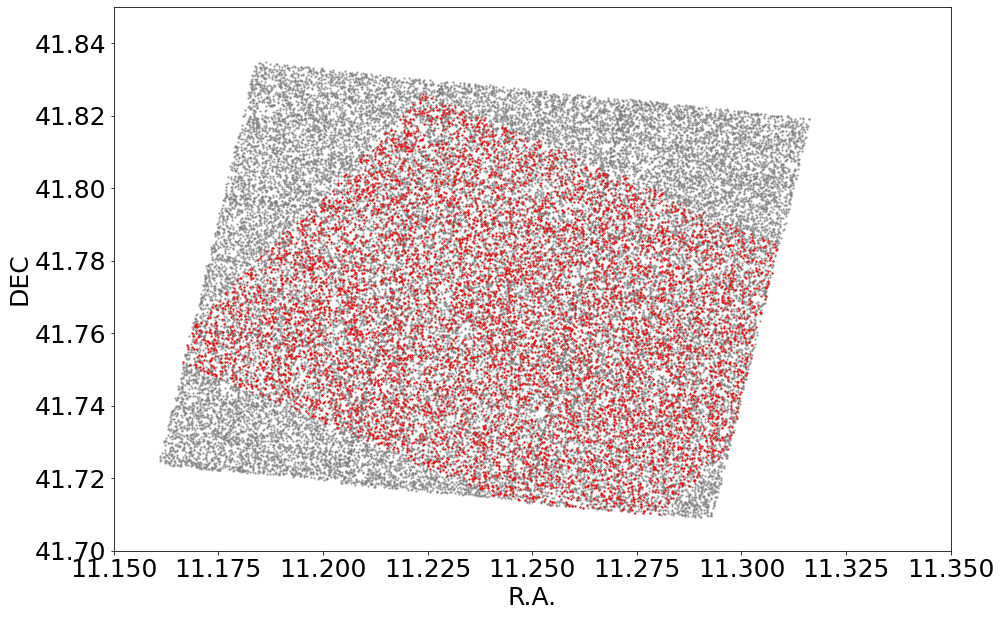

In [202]:

# Get current size
fig_size = plt.rcParams["figure.figsize"]

fig_size[0] = 15
fig_size[1] = 10



plt.scatter(ara_cont, adec_cont, c='Gray', alpha=0.8,s=5,lw=0)
plt.scatter(jrarefs, jdecrefs, c='r', alpha=0.8,s=5,lw=0)
plt.xlabel('R.A.',size=25)
plt.ylabel('DEC',size=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xlim(11.15,11.35)
plt.ylim(41.7,41.85)


In [172]:
# ara_cont_ = (ara_cont*u.degree).to(u.arcsecond)
# adec_cont_ = (adec_cont*u.degree).to(u.arcsecond)

# brightest_in_3p2 = []
# jmag_in_3p2 = []
# jra_in_3p2 = []
# jdec_in_3p2 = []
# pmag1_in_3p2 = []
# pmag2_in_3p2 = []

# for indx, i in tqdm.tqdm_notebook(enumerate(jrarefs)):
#     valra = (i*u.degree).to(u.arcsecond)
#     valdec = (jdecrefs[indx]*u.degree).to(u.arcsecond)
#     mask = (np.abs(valra-ara_cont_)<2.3*u.arcsecond)&(np.abs(valdec-adec_cont_)<2.3*u.arcsecond)\
#                 &(amag2_cont > pmag2refs[indx])
    
# #     print(len(ara_cont_[mask]))
# #     break
#     if len(ara_cont_[mask])==0:
#         brightest_in_3p2.append(jidrefs[indx])
#         jmag_in_3p2.append(jmagrefs[indx])
#         jra_in_3p2.append(jrarefs[indx])
#         jdec_in_3p2.append(jdecrefs[indx])
#         pmag1_in_3p2.append(pmag1refs[indx])
#         pmag2_in_3p2.append(pmag2refs[indx])
#     else:
#         pass

/var/folders/rq/q7l_wtbx4sx5ky0yrvbk7fgh0000gq/T/ipykernel_30838/2502225074.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for indx, i in tqdm.tqdm_notebook(enumerate(jrarefs)):


0it [00:00, ?it/s]

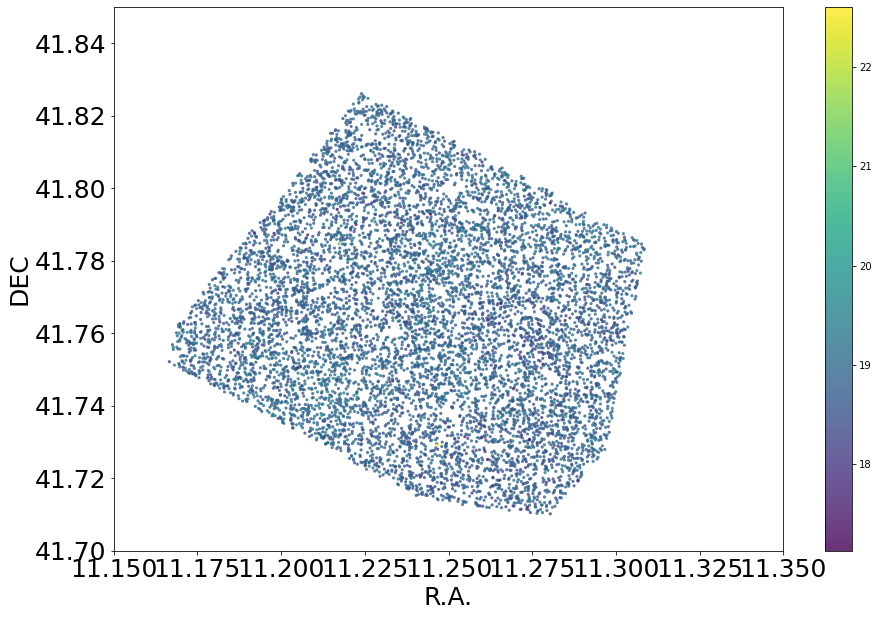

In [203]:

# Get current size
fig_size = plt.rcParams["figure.figsize"]

fig_size[0] = 15
fig_size[1] = 10


plt.figure(facecolor='white')
# plt.scatter(jrarefs, jdecrefs, c='Gray', alpha=0.8,s=5,lw=0)
plt.scatter(jrarefs, jdecrefs, alpha=0.8,s=10,lw=0, c=pmag2refs)
plt.xlabel('R.A.',size=25)
plt.ylabel('DEC',size=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xlim(11.15,11.35)
plt.ylim(41.7,41.85)
plt.colorbar()

In [204]:
print(len(amag2_cont),len(refcoords))

41966 8650


In [205]:
#Select only reference stars that are isolated from bright contaminants.  The problem seems to be happening
#here.  Look at the reference
brightest_in_3p2 = []
jmag_in_3p2 = []
jra_in_3p2 = []
jdec_in_3p2 = []
pmag1_in_3p2 = []
pmag2_in_3p2 = []

for indx, i in tqdm.tqdm_notebook(enumerate(refcoords)):
    #make the list of stars to check (removing the target)
    seps = refcoords[indx].separation(contcoords)    
    nearby = (seps.arcsecond < 2.3)& (amag2_cont < pmag2refs[indx])& (seps > 0.0*u.arcsec)


#     print(len(seps[nearby]),len(seps[~nearby]))
#     break
    if len(seps[nearby])==0:
        brightest_in_3p2.append(jidrefs[indx])
        jmag_in_3p2.append(jmagrefs[indx])
        jra_in_3p2.append(jrarefs[indx])
        jdec_in_3p2.append(jdecrefs[indx])
        pmag1_in_3p2.append(pmag1refs[indx])
        pmag2_in_3p2.append(pmag2refs[indx])
    else:
        pass
    
    
    # here seps[nearby] picks out reference stars not isolated, and seps[~nearby] picks out isolated stars
#     print(len(seps[nearby]))
#    print(i,aidrefs[i],seps[nearby],amag2_cont[nearby])
    
#    print(aidrefs[i],magrefs[i])
#    print(magbrit[nearby],aidbrit[nearby])

    #if brightest within 2.3 arcsec, add to list
#     if len(seps[nearby]) == 0:
        #print(jrarefs[i],aidrefs[i],i)
#        print('')
#     brightest_in_3p2.append(jidrefs[nearby])
#     jmag_in_3p2.append(jmagrefs[nearby])
#     jra_in_3p2.append(jrarefs[nearby])
#     jdec_in_3p2.append(jdecrefs[nearby])
#     pmag1_in_3p2.append(pmag1refs[nearby])
#     pmag2_in_3p2.append(pmag2refs[nearby])



/var/folders/rq/q7l_wtbx4sx5ky0yrvbk7fgh0000gq/T/ipykernel_30838/1024047333.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for indx, i in tqdm.tqdm_notebook(enumerate(refcoords)):


0it [00:00, ?it/s]

In [206]:
print(len(brightest_in_3p2))

2311


(41.7, 41.85)

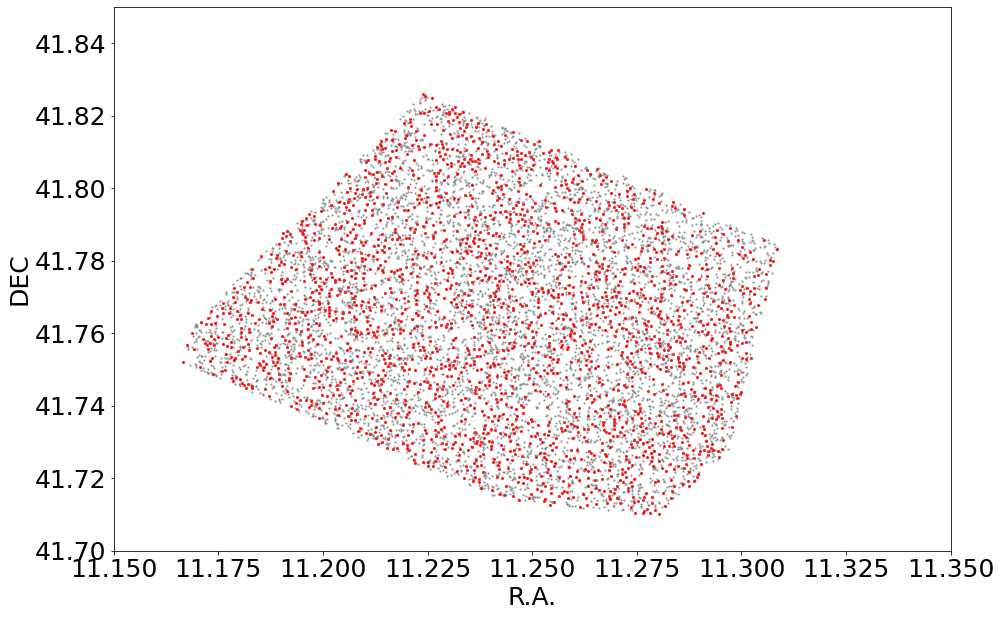

In [209]:

# Get current size
fig_size = plt.rcParams["figure.figsize"]

fig_size[0] = 15
fig_size[1] = 10


plt.figure(facecolor='white')
plt.scatter(jrarefs, jdecrefs, c='Gray', alpha=0.8,s=5,lw=0)
plt.scatter(jra_in_3p2, jdec_in_3p2, c='r', alpha=0.8,s=10,lw=0)
plt.xlabel('R.A.',size=25)
plt.ylabel('DEC',size=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xlim(11.15,11.35)
plt.ylim(41.7,41.85)

# plt.savefig('ref_stars.png',format='png',bbox_inches='tight')




In [ ]:
print(len(brightest_in_3p2))
print(len(jmag_in_3p2))
#print(brightest_in_3p2)


In [ ]:
import pylab as plt

bins = np.linspace(15,25)
plt.hist(jmag_in_3p2, bins, alpha=0.5, histtype='step',linewidth=5, density=False)
plt.xlabel('mags',size=25)
plt.ylabel('Number',size=25)
plt.legend(frameon=False,fontsize=20,handletextpad=0.3,loc='upper left')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


In [ ]:

#Save Cluster star IDs and coordinates to a fits file
#Instructionc collected from https://docs.astropy.org/en/stable/io/fits/#creating-a-new-fits-file
col1 = fits.Column(name='ID', array=brightest_in_3p2, format='K')
col2 = fits.Column(name='RA', array=jra_in_3p2, format='D')
col3 = fits.Column(name='DEC', array=jdec_in_3p2, format='D')
col4 = fits.Column(name='MAG1_IR', array=pmag1_in_3p2, format='F')
col5 = fits.Column(name='MAG2_IR', array=pmag2_in_3p2, format='F')
col6 = fits.Column(name='F115W', array=jmag_in_3p2, format='F')
cols = fits.ColDefs([col1,col2,col3,col4,col5,col6])
hdu = fits.BinTableHDU.from_columns(cols)
hdu.writeto('reference_stars.fits')

print(seps[nearby])


# Testing Area

In [ ]:
#This one contains stars with not so good astrometry, that won't serve as targets or reference stars
#but which could be contaminants

#Select range of magnitudes for reference stars
bri_lim = 19.0
fai_lim = 20.0


bright_contaminants = (jmag < fai_lim)
jra_cont = jra[bright_contaminants]
jdec_cont = jdec[bright_contaminants]
jmag_cont = jmag[bright_contaminants]

contcoords = SkyCoord(ra=jra_cont*u.deg, dec=jdec_cont*u.deg)


In [ ]:
#Select only reference stars that are isolated from bright contaminants
brightest_in_box = []

for i in tqdm.tqdm(range(len(magrefs))):
#for i in tqdm.tqdm(range(173,175)):
    #make the list of stars to check (removing the target)
    seps = refcoords[i].separation(skycoords)
    nearby = ( (seps < 2.3*u.arcsec) & (seps > 0.0*u.arcsec) & (magbrit < magrefs[i]) )
    
#    print(aidrefs[i],magrefs[i])
#    print(magbrit[nearby],aidbrit[nearby])

    #if brightest within 2.3 arcsec, add to list
    if len(seps[nearby]) == 0:
        brightest_in_box.append(aidrefs[i])
    


In [ ]:
print(len(seps[nearby]),len(nearby[True]))
print(seps[nearby])
print(magbrit[nearby])

In [ ]:
print(len(brightest_in_box))
#print(brightest_in_3p2)


In [ ]:

#make a list of all stars with no neighbours brighter than reference mag = 23.3 in 0.3 arcsec:
mask = af1 < 23.3
data = np.dstack([ara, ade])[0]
tree = cKDTree(data)
bright_in_0p3 = tree.query_ball_point(data, 0.3/3600)
print(bright_in_0p3)
close_neighbour = np.ones(len(bright_in_0p3), dtype=bool)
for i in range(len(bright_in_0p3)):
    if len(bright_in_0p3[i]) == 1:
        close_neighbour[i] = 0
        
brightest_in_3p2_mask = np.zeros(len(ara), dtype=bool)
brightest_in_3p2_mask[brightest_in_3p2] = 1
        
#finally, make the list of magnitude differences
all_deltamag = np.ones(len(ara))*np.nan
all_deltamag[brightest_in_3p2_mask] = deltamag

refmask = brightest_in_3p2_mask & ~close_neighbour & (af1 < 22.) & (af1 > 20.3) & (all_deltamag > 1.5)

reference = np.zeros(len(ara), dtype=bool)
reference[refmask] = 1


#Save Cluster star IDs and coordinates to a fits file
#Instructionc collected from https://docs.astropy.org/en/stable/io/fits/#creating-a-new-fits-file
col1 = fits.Column(name='ID', array=aid, format='30A')
col2 = fits.Column(name='RA_final', array=ara, format='F')
col3 = fits.Column(name='DEC_final', array=ade, format='F')
col4 = fits.Column(name='NRS_F110W', array=af1, format='F')
col5 = fits.Column(name='MAG_err', array=aer, format='F')
col6 = fits.Column(name='Weight', array=awe, format='F')
col7 = fits.Column(name='Reference', array=are, format='I')
col8 = fits.Column(name='Comment', array=aco, format='30A')
col9 = fits.Column(name='label', array=ala, format='30A')
cols = fits.ColDefs([col1,col2,col3,col4,col5,col6,col7,col8,col9])
hdu = fits.BinTableHDU.from_columns(cols)
hdu.writeto('reference_targets.fits')



In [ ]:
refstars = are==1
print(len(are[refstars]))

In [ ]:
print(af1[refstars])